In [2]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import morph_geom_lib as mgl
import models.shallow_depth_morph_models as sdmodels
import schemes.avalanche_scheme 
from scipy.signal import find_peaks

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
#plt.style.use(['dark_background'])

In [3]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

dx: 0.5786548082267927 cm
nx 1800


Text(0, 0.5, 'z (m)')

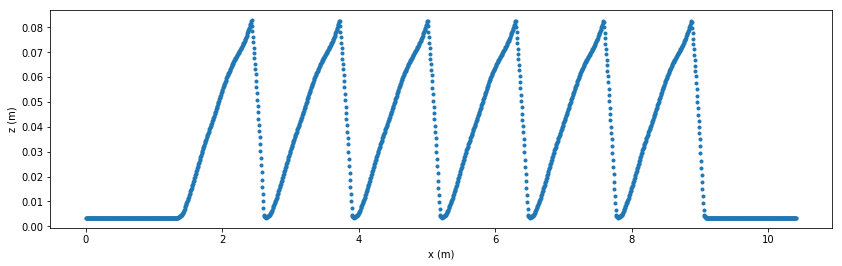

In [4]:
filepath = 'dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1800)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

## 32 Centimeter Case

In [5]:
import pandas as pd
filepath = r'/data/LRN-WallTreatments-openFOAM-5.x/validation//QueensFlume/35.7.cm/dune.127z.30r.s.9.6.colebrook.yp.0.x/300/wallShearStress.txt'
print(os.path.exists(filepath))
tau32df = pd.read_csv(filepath, sep='\t', index_col=0)

filepath = r'/data/LRN-WallTreatments-openFOAM-5.x/validation//QueensFlume/23.7.cm/dune.100z.40r.s.0.96.colebrook.yp.0.x/300/wallShearStress.txt'
tau20df = pd.read_csv(filepath, sep='\t', index_col=0)

xc = tau32df.index

True


2019-05-29 19:21:11,989 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-29 19:21:30,805 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-29 19:21:49,254 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-29 19:22:03,591 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-29 19:22:16,641 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-29 19:22:29,100 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-29 19:22:41,241 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-29 19:22:53,330 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-29 19:23:05,856 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-29 19:23:19,255 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-29 19:23:31,400 INFO CLAW: Solution 10 computed for time t=300.000000
Mean U: 0.5747907246026426
Surface: 0.34850474524699404


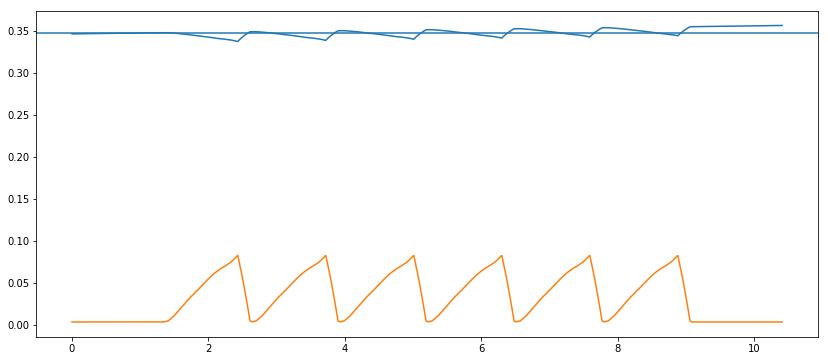

In [6]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)

model.set_Dirichlet_BC(sOut32, q32cm)
model.set_inital_conditions(sOut32, 0.0)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h32 = model.get_hf()
u32 = model.get_uf()
surf32 = h32 + z0

tau32_shallow = [sedtrans.get_bed_shear(h32[i], u32[i], D50) for i in range(len(u32))]


fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf32)
plt.plot(x0, z0)


#print('Elevation at outlet'.format(surf[len(x0)-1]))
print('Mean U: {0}'.format(u32.mean()))
print('Surface: {0}'.format(surf32.mean()))
plt.axhline(surf32.mean())

Text(0, 0.5, 'Bed Shear [N/m2]')

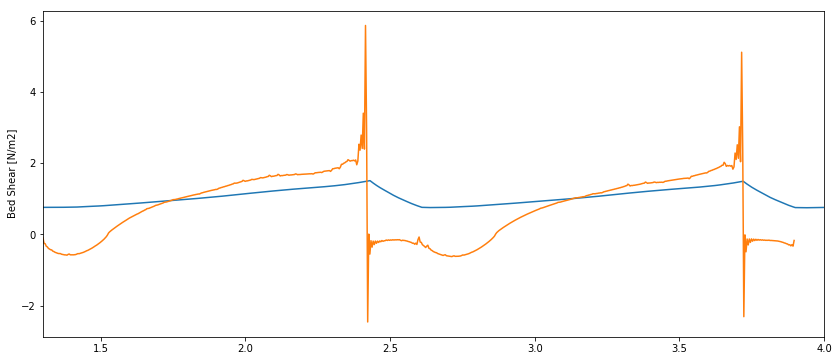

In [7]:
fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, surf32)
#plt.plot(x0, z0)

plt.plot(x0, tau32_shallow)
plt.plot(xc+1.3, tau32df.tau*-1000)

plt.xlim([1.3, 4.0])
plt.ylabel('Bed Shear [N/m2]')

## Compare bedloads

Text(0, 0.5, 'Bed load')

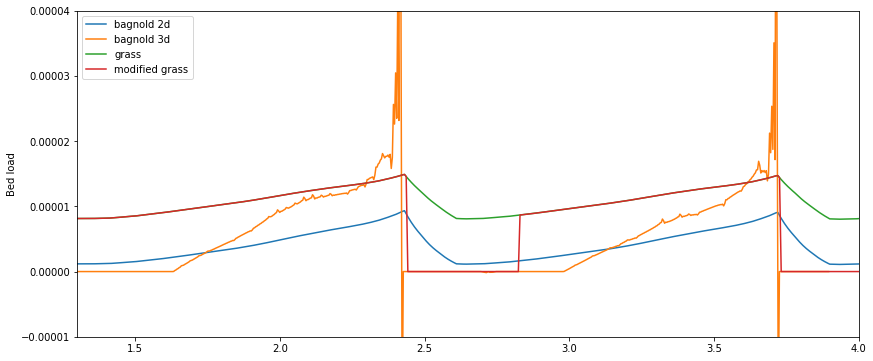

In [8]:
tau_32_3d = list(tau32df.tau*-1000.)
qb_32_3d  = [sedtrans.get_unit_bed_load(tau=tau_32_3d[i], D0=D50, method='bagnold') for i in range(len(tau_32_3d))]

qb_32_2d = [sedtrans.get_unit_bed_load(tau=tau32_shallow[i], D0=D50, method='bagnold') for i in range(len(tau32_shallow))] 


a = 0.00005
b = 5

a = 0.00003
b = 2.

qb_32_2d_grass = (a*u32*np.abs(u32) **(b-1.))


model = sdmodels.ModifiedShallowHydroMorphologicalModel()
#model.set_scale_factor(2)
#model.use_modifier()
#model.use_periodic_reattachment()
 
qb_32_2d_grass_modified = model._modify_bedload( qb_32_2d_grass, x0, z0,100)

#qb_32_2d_bagnold_modified = model._modify_bedload( qb_32_2d, x0, z0, 10)

fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, surf32)
#plt.plot(x0, z0)

plt.plot(x0, qb_32_2d, label='bagnold 2d')
plt.plot(xc+1.3, qb_32_3d, label='bagnold 3d')

plt.plot(x0, qb_32_2d_grass, label='grass')
#plt.plot(x0, qb_32_2d_bagnold_modified, label="modified bag")
plt.plot(x0, qb_32_2d_grass_modified, label='modified grass')
plt.legend()
plt.xlim([1.3, 4.0])
plt.ylim([-0.00001,0.00004])
plt.ylabel('Bed load')

## 20 cm Case

2019-05-24 18:15:31,189 INFO CLAW: Solution 0 computed for time t=0.000000
2019-05-24 18:15:36,489 INFO CLAW: Solution 1 computed for time t=30.000000
2019-05-24 18:15:42,259 INFO CLAW: Solution 2 computed for time t=60.000000
2019-05-24 18:15:50,114 INFO CLAW: Solution 3 computed for time t=90.000000
2019-05-24 18:15:56,581 INFO CLAW: Solution 4 computed for time t=120.000000
2019-05-24 18:16:01,501 INFO CLAW: Solution 5 computed for time t=150.000000
2019-05-24 18:16:06,399 INFO CLAW: Solution 6 computed for time t=180.000000
2019-05-24 18:16:11,281 INFO CLAW: Solution 7 computed for time t=210.000000
2019-05-24 18:16:16,023 INFO CLAW: Solution 8 computed for time t=240.000000
2019-05-24 18:16:21,009 INFO CLAW: Solution 9 computed for time t=270.000000
2019-05-24 18:16:26,144 INFO CLAW: Solution 10 computed for time t=300.000000
Elevation at outlet
Mean U: 0.41235915520881394
Surface: 0.2293615910972559


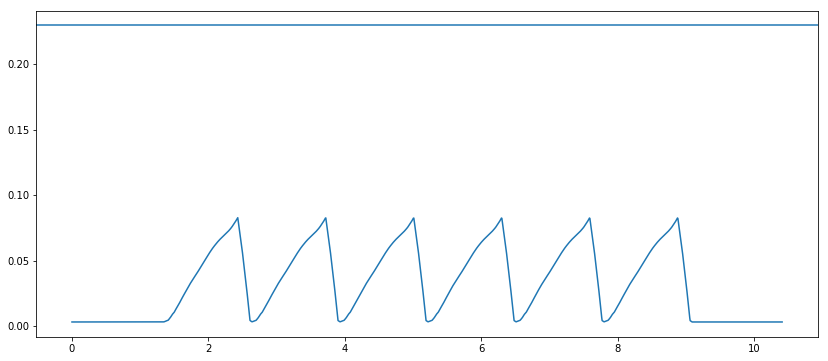

In [135]:
#--------------------------------
# Initalize the model
#--------------------------------
model = shallow_water_solver(kernel_language='Fortran')
model.set_solver(max_steps=1000000)
model.set_state_domain(x0, z0)
model.set_chezy_source_term(ks = ks, slope = bed_slope)

model.set_Dirichlet_BC(sOut20, q20cm)
model.set_inital_conditions(sOut20, 0.0)
model.set_controller(tfinal = 300, num_output_times=10)
model.run()

h20 = model.get_hf()
u20 = model.get_uf()
surf20 = h20 + z0

tau20_shallow = [sedtrans.get_bed_shear(h20[i], u20[i], D50) for i in range(len(u20))]


fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, surf20)
plt.plot(x0, z0)


print('Elevation at outlet'.format(surf20[len(x0)-1]))
print('Mean U: {0}'.format(u20.mean()))
print('Surface: {0}'.format(surf20.mean()))
plt.axhline(surf20.mean())

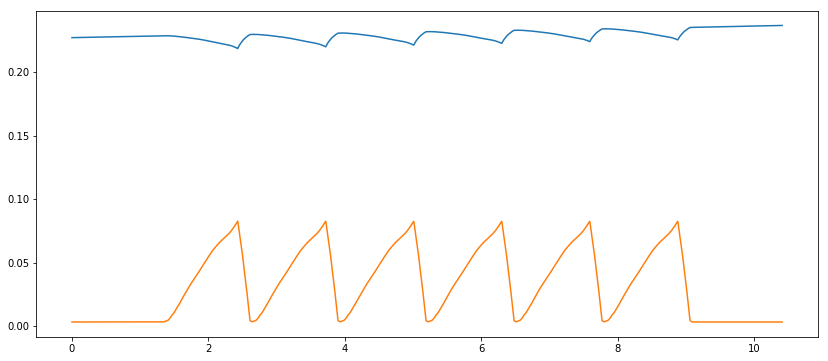

In [137]:
h20 = model.get_hf()
u20 = model.get_uf()
surf20 = h20 + z0
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, surf20)
plt.plot(x0, z0)

Text(0, 0.5, 'Bed Shear [N/m2]')

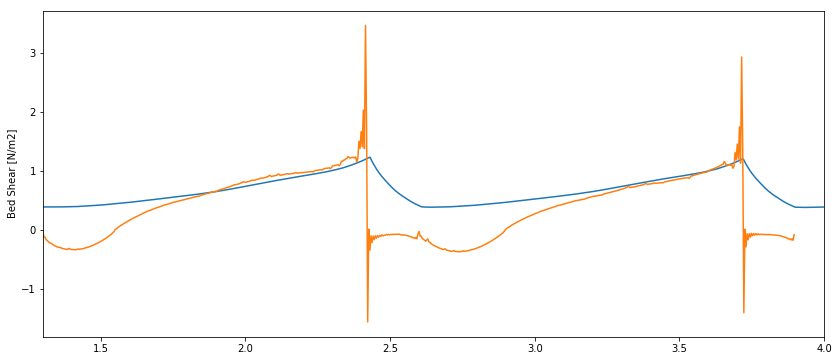

In [139]:
fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, surf32)
#plt.plot(x0, z0)

plt.plot(x0, tau20_shallow)
plt.plot(xc+1.3, tau20df.tau*-1000)

plt.xlim([1.3, 4.0])
plt.ylabel('Bed Shear [N/m2]')

Text(0, 0.5, 'Bed load')

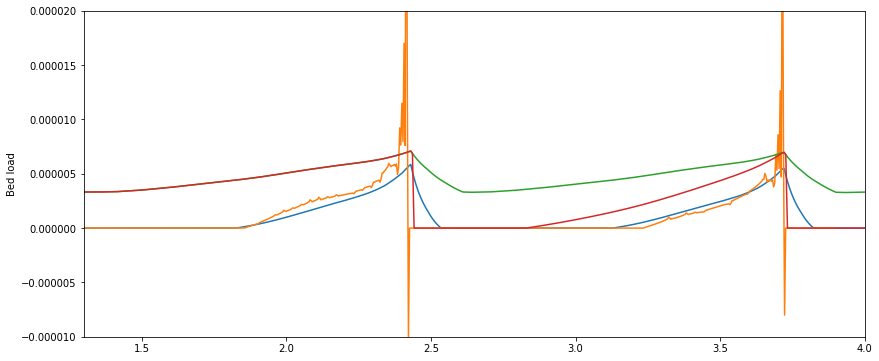

In [321]:
tau_20_3d = list(tau20df.tau*-1000.)
qb_20_3d  = [sedtrans.get_unit_bed_load(tau=tau_20_3d[i], D0=D50, method='bagnold') for i in range(len(tau_20_3d))]

qb_20_2d = [sedtrans.get_unit_bed_load(tau=tau20_shallow[i], D0=D50, method='bagnold') for i in range(len(tau20_shallow))] 


a = 0.000016
b = 1.5
qb_20_2d_grass = (a*u20*(u20) **(b-1.))


model = sdmodels.ModifiedShallowHydroMorphologicalModel()
 
qb_20_2d_grass_modified = model._modify_bedload( qb_20_2d_grass, x0, z0, 1)

fig = plt.figure(figsize=(14, 6))
#plt.plot(x0, surf32)
#plt.plot(x0, z0)

plt.plot(x0, qb_20_2d)
plt.plot(xc+1.3, qb_20_3d)

plt.plot(x0, qb_20_2d_grass)

plt.plot(x0, qb_20_2d_grass_modified)

plt.xlim([1.3, 4.0])
plt.ylim([-0.00001,0.00002])
plt.ylabel('Bed load')

Text(0, 0.5, 'Bed load')

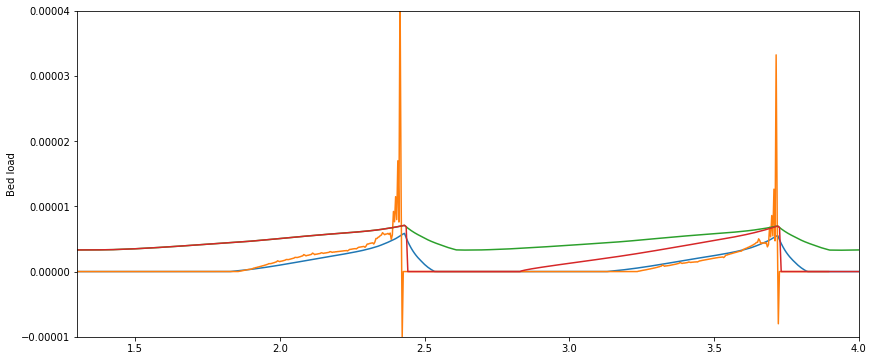

## Vortex shedding simulation

The flows generated by asymmetrical dunes are highly unsteady and large turbulent structures with length scales as large as the step height are produced and pass through the reattachment region.  Simpson (1989) found that the non-dimensional frequency range generated by the vortex shedding is fxr/Uo 0.6-0.8 where f is the frequency and Uo is a characteristic mean velocity. Simpson (1989) also states that the motion of the reattaching shear layer generates a very low frequency "flapping" motion with a non-dimensional frequency of fxr/Uo< 0.1.The flapping motion is thought to be produced when a high-momentum turbulent structure delays the flow reattachment. This results in a larger pressure gradient resulting in greater backflow later in time.

In [204]:
Uo = 0.45
fxr = 0.7*Uo

print('{0} cycles per second'.format(fxr))

0.315 cycles per second


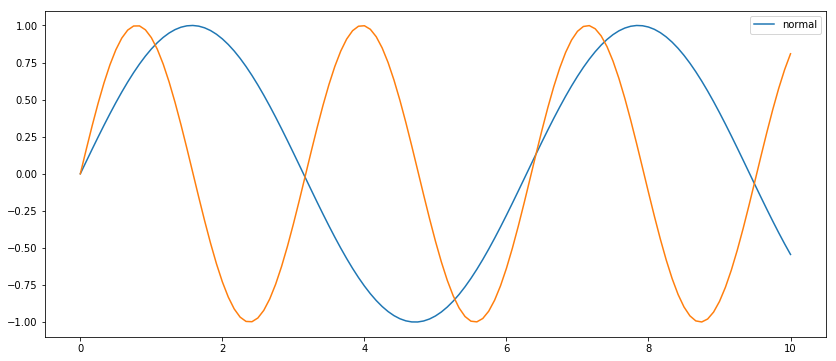

In [228]:
fig = plt.figure(figsize=(14, 6))

t = np.linspace(0, 10, 121)

x = np.sin(t)

xr = np.sin(2*math.pi*fxr*t)


plt.plot(t, x, label='normal')
plt.plot(t, xr)

plt.legend()

In [226]:
1/fxr

3.1746031746031744